In [1]:
import pandas as pd
import sqlite3
import os

import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [2]:
# Open SQL Database and initialize dataframe
path = "../Algorithm/data"
conn = sqlite3.connect("C:\\Users\\charl\\Desktop\\Algorithm\\data\\Prediction.db")
df = pd.read_sql_query("SELECT * FROM BLAZERS", conn)

In [31]:
# Add remaining teams to the end of the dataframe
teams = ["BLAZERS", "BUCKS", "BULLS", "CAVALIERS", "CELTICS", "CLIPPERS", "GRIZZLIES", "HAWKS", "HEAT", "HORNETS", "JAZZ", "KINGS", "KNICKS", "LAKERS", "MAGIC", "MAVERICKS", "NETS", "NUGGETS", "PACERS", "PELICANS", "PISTONS", "RAPTORS", "ROCKETS", "SIXERS", "SPURS", "SUNS", "THUNDER", "TIMBERWOLVES", "WARRIORS", "WIZARDS"]

for team in teams[1:]:
    temp_df = pd.read_sql_query("SELECT * FROM " + team, conn)
    df = pd.concat([df, temp_df], axis=0)

In [32]:
df

,ts_1,ts_final,home_ppg,home_oppg,away_ppg,away_oppg,game_ID,game_date,home_team,away_team,...,TO_2,three_m2,three_a2,ts_2,diff_2,TO_3,three_m3,three_a3,ts_3,diff_3
0,52,245.0,115.0,116.1,110.7,108.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71,239.0,115.0,116.1,116.3,109.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53,212.0,115.0,116.1,117.8,114.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,65,275.0,115.0,116.1,112.6,113.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,64,236.4,115.0,116.1,113.6,113.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,53,187.0,100.7,99.4,98.6,99.4,21300189.0,2013-11-23,WIZARDS,KNICKS,...,4.0,2.0,5.0,101.0,3.0,5.0,4.0,18.0,145.0,7.0
284,61,204.0,100.7,99.4,106.9,104.3,21300156.0,2013-11-19,WIZARDS,TIMBERWOLVES,...,2.0,3.0,9.0,114.0,12.0,9.0,4.0,12.0,162.0,0.0
285,43,199.0,100.7,99.4,98.2,101.5,21300138.0,2013-11-16,WIZARDS,CAVALIERS,...,8.0,7.0,13.0,93.0,5.0,5.0,1.0,6.0,133.0,5.0
286,60,220.0,100.7,99.4,98.5,99.5,21300077.0,2013-11-08,WIZARDS,NETS,...,9.0,5.0,10.0,111.0,5.0,12.0,1.0,13.0,146.0,0.0


In [33]:
#df.to_csv("../data/2016-2018_save.csv")

In [34]:
df.head()

,ts_1,ts_final,home_ppg,home_oppg,away_ppg,away_oppg,game_ID,game_date,home_team,away_team,...,TO_2,three_m2,three_a2,ts_2,diff_2,TO_3,three_m3,three_a3,ts_3,diff_3
0,52,245.0,115.0,116.1,110.7,108.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71,239.0,115.0,116.1,116.3,109.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53,212.0,115.0,116.1,117.8,114.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,65,275.0,115.0,116.1,112.6,113.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,64,236.4,115.0,116.1,113.6,113.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df['avg_points_scored'] = (df['home_ppg'] + df['away_ppg'])/2
df['avg_points_allowed'] = (df['home_oppg'] + df['away_oppg'])/2
df["TO_2"] = df["TO_2"] + df["TO_1"]
df['TO_3'] = df["TO_3"] + df["TO_2"]
df["three_a2"] = df["three_a2"] + df["three_a1"]
df['three_a3'] = df["three_a3"] + df["three_a2"]
df["three_m2"] = df["three_m2"] + df["three_m1"]
df['three_m3'] = df["three_m3"] + df["three_m2"]


In [36]:
df.head()

,ts_1,ts_final,home_ppg,home_oppg,away_ppg,away_oppg,game_ID,game_date,home_team,away_team,...,three_a2,ts_2,diff_2,TO_3,three_m3,three_a3,ts_3,diff_3,avg_points_scored,avg_points_allowed
0,52,245.0,115.0,116.1,110.7,108.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.85,112.25
1,71,239.0,115.0,116.1,116.3,109.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.65,113.00
2,53,212.0,115.0,116.1,117.8,114.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.40,115.45
3,65,275.0,115.0,116.1,112.6,113.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.80,114.90
4,64,236.4,115.0,116.1,113.6,113.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.30,114.75


In [37]:
# delete unusable variables
# Score diff helpful for 3q, not for 1st
#df = df[['ts_1','ts_final', 'home_ppg', 'home_oppg', 'away_ppg', 'away_oppg']]
df = df[['ts_1','ts_final', 'avg_points_scored', 'avg_points_allowed']]

In [38]:
#df['percent_3pt'] = df['three_m1']/df['three_a1']

In [39]:
df.sample(20)

,ts_1,ts_final,avg_points_scored,avg_points_allowed
42,65,218.0,109.80,114.20
8,39,220.0,112.25,111.80
228,51,178.0,93.35,99.15
134,61,234.0,111.00,109.20
39,47,175.0,108.20,108.85
22,53,192.0,106.15,108.55
189,48,202.0,102.50,100.40
186,57,236.0,100.60,101.85
69,51,243.0,116.40,109.90
232,40,219.0,102.30,100.45


,ts_1,ts_final,avg_points_scored,avg_points_allowed
ts_1,1.000000,0.576908,0.321671,0.315704
ts_final,0.576908,1.000000,0.462885,0.447587
avg_points_scored,0.321671,0.462885,1.000000,0.794629
avg_points_allowed,0.315704,0.447587,0.794629,1.000000


<AxesSubplot:>

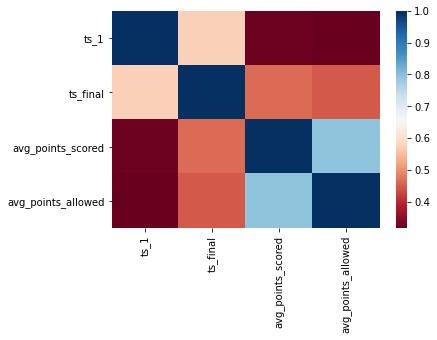

In [40]:
# check for multicolinearity
corr = df.corr()
display(corr)

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [41]:
# Given all of our variables have low correlation values (well under 5), we can confirm they are okay to be included
desc = df.describe()
desc

,ts_1,ts_final,avg_points_scored,avg_points_allowed
count,16764.000000,16764.000000,16764.000000,16764.000000
mean,52.663863,210.267728,105.413502,105.451354
std,8.674515,22.093394,5.152187,4.995925
min,20.000000,0.800000,91.950000,92.050000
25%,47.000000,195.000000,101.500000,101.500000
50%,52.000000,209.000000,104.950000,105.100000
75%,58.000000,225.000000,109.450000,109.150000
max,89.000000,329.000000,118.250000,119.400000


In [42]:
#df = df[df['diff_1'] < 29]
df = df[df['ts_final'] > 100]
df = df[df['ts_final'] < 310]


In [43]:
#build the model
X = df.drop('ts_final', axis = 1)
Y = df["ts_final"]

#Split data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Fit the model
regression_model = LinearRegression()
regression_model.fit(X_train, Y_train)

LinearRegression()

In [44]:
# Print out results of the model
intercept = regression_model.intercept_
coefficent = regression_model.coef_[0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

for coef in zip(X.columns, regression_model.coef_):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is -11.0
----------------------------------------------------------------------------------------------------
The Coefficient for ts_1 is 1.2
The Coefficient for avg_points_scored is 0.88
The Coefficient for avg_points_allowed is 0.63


In [45]:
Y_predict = regression_model.predict(X_test)

In [46]:
Y_predict

array([230.20038128, 202.20827977, 216.58926067, ..., 220.35768875,
       202.08729283, 221.69088262])

In [47]:
print('Train Score :', regression_model.score(X_train,Y_train))
print('Test Score:', regression_model.score(X_test,Y_test))

Train Score : 0.43735288050155574
Test Score: 0.43778332291463107


In [48]:
# Applying model to be used with the statsmodel package (needs a constant) 
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)


# fit the data
est = model.fit()
est.pvalues
# TO, ts, all pgg

const                 1.086256e-04
ts_1                  0.000000e+00
avg_points_scored     1.040559e-97
avg_points_allowed    1.567811e-53
dtype: float64

In [49]:
#White's test for heteroscedasticity
_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

2.0652996381820544e-53 7.322727694158684e-54
----------------------------------------------------------------------------------------------------
For the White's Test
The p-value was 2.065e-53
2.244119216690491e-28 1.756895188189011e-28
----------------------------------------------------------------------------------------------------


In [50]:
model = sm.OLS(Y, X2)
est = model.fit()

_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog)
print(pval, f_pval)

2.0652996381820544e-53 7.322727694158684e-54


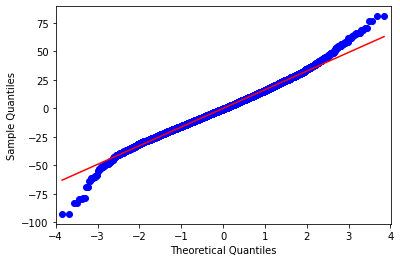

The mean of the residuals is -3.238e-15


In [51]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

In [52]:
import math
# calculate the mean squared error
model_mse = mean_squared_error(Y_test, Y_predict)

# calculate the mean absolute error
model_mae = mean_absolute_error(Y_test, Y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 2.6e+02
MAE 12.6
RMSE 16.1


In [53]:
model_r2 = r2_score(Y_test, Y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.44


In [54]:
est.conf_int()

,0,1
const,-16.238283,-5.322137
ts_1,1.150814,1.211455
avg_points_scored,0.779588,0.939122
avg_points_allowed,0.565621,0.729899


In [55]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               ts_final   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     4343.
Date:                Thu, 17 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:26:36   Log-Likelihood:                -70600.
No. Observations:               16757   AIC:                         1.412e+05
Df Residuals:                   16753   BIC:                         1.412e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.7802      2

In [ ]:
import csv
with open('../training_combinations/quarter_2_combo.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for key in ppg.keys():
        row = [key, ppg[key], oppg[key]]
        writer.writerow(row)

In [56]:
import pickle

# pickle the model
with open('../Models/predict_1.sav','wb') as f:
     pickle.dump(regression_model, f)